In [1]:
from transformers import RobertaTokenizer, TFRobertaModel
import datasets
import tensorflow as tf
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

/home/brody/school/38_ve/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [5]:
wiki = datasets.load_dataset("wikitext",'wikitext-103-v1')

Reusing dataset wikitext (/home/brody/.cache/huggingface/datasets/wikitext/wikitext-103-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)
100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 1036.57it/s]


In [8]:
MAX_LENGTH = 500

In [248]:
def create_wiki_set(data_set_type='train',n=10000):
    overflow = ''
    examples = []
    for index,i in tqdm(enumerate(wiki[data_set_type]['text'])):
        buffer = overflow + i
        if len(buffer) >= MAX_LENGTH:
            examples.append(buffer[:MAX_LENGTH])
            overflow = ''
        else:
            overflow += i
        if index >= n:
            break
    return examples


In [249]:
wiki_examples = create_wiki_set(data_set_type='train',n=10)
print(wiki_examples[0])

10it [00:00, 146143.00it/s]

 = Valkyria Chronicles III = 
 Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs paralle


In [5]:
outputs

TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<tf.Tensor: shape=(1, 8, 768), dtype=float32, numpy=
array([[[-0.04778079,  0.08856517, -0.00979672, ..., -0.05444449,
         -0.06716338, -0.00391623],
        [-0.07121383,  0.01499833, -0.1298776 , ...,  0.06383334,
          0.02963825, -0.08603133],
        [ 0.09055017,  0.14373958,  0.08283181, ...,  0.05086066,
         -0.03197741, -0.04901589],
        ...,
        [ 0.08531624,  0.21548253,  0.08490154, ..., -0.11496733,
          0.03299987, -0.07903446],
        [ 0.16793376,  0.128793  ,  0.00646019, ...,  0.03671372,
         -0.06305141,  0.02762577],
        [-0.04356978,  0.08920526, -0.03888651, ..., -0.09573355,
         -0.07437792, -0.02838535]]], dtype=float32)>, pooler_output=<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-3.20835412e-03, -2.19398811e-01, -2.10875914e-01,
        -7.67211840e-02,  1.20515734e-01,  2.04878107e-01,
         2.60702759e-01, -8.43434557e-02, -7.25212172e-0

In [3]:
def build_base_roberta(learning_rate = 0.00001,
                      dropout=0.3,
                      hidden_size=100):
    
    model = TFRobertaModel.from_pretrained("roberta-base")
    
    input_ids = tf.keras.layers.Input(shape=(100,), dtype=tf.int64, name='input_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(100,), dtype=tf.int64, name='attention_mask_layer')
    

    bert_inputs = {'input_ids': input_ids,
                   'attention_mask': attention_mask}         

    bert_out = model(bert_inputs)[1]
    
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(bert_out)
    dropped = tf.keras.layers.Dropout(dropout)(hidden)  

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(dropped)

    
    detection_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])
    
    detection_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                            loss='binary_crossentropy', 
                            metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]) 
    return detection_model
    

In [4]:
with open('/home/brody/school/w266/data/generated_wiki_text_10k.data', 'rb') as f:
    generated_texts = pickle.load(f)

In [5]:
len(generated_texts[0].split())

145

In [6]:
for i in generated_texts[10:20]:
    print(i)
    print('------------------------------------------------------------------------')
    print('------------------------------------------------------------------------')

. At the height of his popularity in 1882 he became one of Europe's leading entertainers. He became one of Europe's most well @-@ known musicians, selling over 10 @,@ 000 @,@ 000 albums as of 2015. He is widely regarded as one of Europe's most successful musicians, receiving accolades such as the Royal Philharmonic Lifetime Achievement Award in 2002. He was inducted into the Grammy Hall of Fame in 1988, and continues to perform at the Academy of Motion Picture Arts and Sciences every year thereafter, and has been featured on Rolling Stone's list of America's 100 Greatest Musicians of All @-@ Decade. 
 = = Early life = = 
 John Lewis Lewis was born on March 3, 1872, the youngest son of James Lewis and Margaret Alice Lewis. He grew up in New Haven, New Haven, Connecticut, where he moved with his mother and elder brother to Providence, Rhode Island when he was four years of age. Shortly thereafter, his parents emigrated to the West Indies, where it was rumoured that the Lewis family was d

In [9]:
cleaned_gen = []
for example in generated_texts:
    if len(example) >= MAX_LENGTH:
        cleaned_gen.append(example[:MAX_LENGTH])

In [10]:
print(len(cleaned_gen))
random.shuffle(cleaned_gen)

9900


In [11]:
print(cleaned_gen[0])

 was cancelled due to technical troubles caused by a lackadaisical decision on the part of Warner Brothers to delay publication of the game. It was cancelled again on November 2, 2008 due to technical problems resulting from a shortage of space. It was re @-@ released on January 1, 2009 for Windows Vista and as part of Sony Computer Entertainment's ( Sony Computer Entertainment ) Greatest Hits series on December 19, 2007. 
 In an interview in April 2010, Nintendo president Reggie Fils @-@ Aimé e


In [255]:
cleaned_wiki_train = create_wiki_set(data_set_type='train',n=35000)

35000it [00:00, 2390267.03it/s]


In [256]:
print(len(cleaned_wiki_train))
print(cleaned_wiki_train[:4])

11321
[' = Valkyria Chronicles III = \n Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs paralle', " The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more forgiving for series newcomers . Character designer <unk> Honjou and composer Hitoshi Sakimoto both returned from previous entries , along with Valkyria Chronicles II director Takeshi Ozawa . A large team of writers handled the script . The game 's

In [264]:
with open('/home/brody/school/w266/data/cleaned_generated_text_wn.data', 'wb') as f:
    pickle.dump(cleaned_gen, f)
with open('/home/brody/school/w266/data/cleaned_wiki_text_wn.data', 'wb') as f:
    pickle.dump(cleaned_wiki_train, f)

In [12]:
with open('/home/brody/school/w266/data/cleaned_generated_text_wn.data', 'rb') as f:
    cleaned_gen = pickle.load(f)
with open('/home/brody/school/w266/data/cleaned_wiki_text_wn.data', 'rb') as f:
    cleaned_wiki_train = pickle.load(f)

In [13]:
cleaned_wiki = cleaned_wiki_train[:len(cleaned_gen)]
print(len(cleaned_wiki))

9900


### 0 for human, 1 for bot

In [14]:
wiki_train_labels = np.array([0]*(len(cleaned_wiki)-500) + [1]*(len(cleaned_gen)-500))
wiki_val_labels = np.array([0]*500+[1]*500)

In [15]:
train_texts = cleaned_wiki[:-500] + cleaned_gen[:-500]
val_texts = cleaned_wiki[-500:] + cleaned_gen[-500:]

In [16]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=100, return_tensors='tf')
valid_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=100, return_tensors='tf')

2022-07-24 20:56:23.354532: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-24 20:56:23.386498: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-24 20:56:23.386624: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-24 20:56:23.387046: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [17]:
bert_model = build_base_roberta(learning_rate = 0.00001,
                      dropout=0.35,
                      hidden_size=150)
bert_model.summary()
bert_model_history = bert_model.fit([train_encodings.input_ids, train_encodings.attention_mask], 
                                                  wiki_train_labels,   
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.attention_mask], 
                                                  wiki_val_labels),    
                                                  batch_size=8, 
                                                  epochs=2, shuffle=True,)  

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 100)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 100)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['attention_mask_layer[0][0]',   
 el)                            thPoolingAndCrossAt               'input_ids_layer[0][0]']        
                                tentions(last_hidde                                           

In [27]:
def make_plot(axs, history1, 
              y_lim_loss_lower=0.0, 
              y_lim_loss_upper=0.05,
              y_lim_accuracy_lower=0.95, 
              y_lim_accuracy_upper=1,
              model_1_name='model 1',
              
             ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    ax1 = axs[0]
    ax1.plot(history1.history['loss'])
    ax1.plot(history1.history['val_loss'])
    ax1.set_title('loss - ' + model_1_name)
    ax1.set_ylabel('loss', bbox=box)
    ax1.set_ylim(y_lim_loss_lower, y_lim_loss_upper)

    ax3 = axs[1]
    ax3.set_title('accuracy - ' + model_1_name)
    ax3.plot(history1.history['accuracy'])
    ax3.plot(history1.history['val_accuracy'])
    ax3.set_ylabel('accuracy', bbox=box)
    ax3.set_ylim(y_lim_accuracy_lower, y_lim_accuracy_upper)

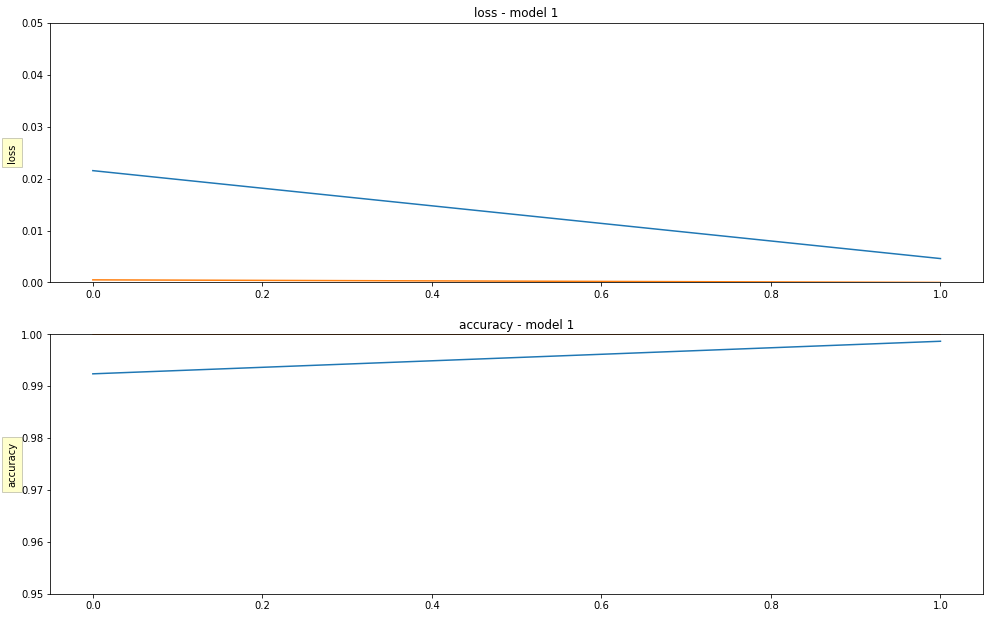

In [29]:
fig, axs = plt.subplots(2, 1)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs, 
          bert_model_history,
         y_lim_accuracy_lower=0.95,
         y_lim_accuracy_upper=1)

fig.align_ylabels(axs)
fig.set_size_inches(18.5, 10.5)
plt.show()

In [30]:
with open('/home/brody/school/w266/baseline_roberta/best_baseline.data', 'wb') as f:
    pickle.dump(bert_model, f)

INFO:tensorflow:Assets written to: ram://93e33ab8-d981-4ae0-9789-82ec4a24c090/assets


INFO:tensorflow:Assets written to: ram://93e33ab8-d981-4ae0-9789-82ec4a24c090/assets


In [31]:
bert_model.save('/home/brody/school/w266/baseline_roberta/keras_model')

INFO:tensorflow:Assets written to: /home/brody/school/w266/baseline_roberta/keras_model/assets


INFO:tensorflow:Assets written to: /home/brody/school/w266/baseline_roberta/keras_model/assets


## Tweep Fake data set

In [32]:
tweep_val = pd.read_csv('/home/brody/school/w266/tweep_fake/validation.csv')

In [66]:
tweep_val.head()

,screen_name,text,account.type,class_type,labels
0,ahadsheriff,"TIGHT, TIGHT, TIGHT, YEAH!!! https://t.co/wj3n...",human,human,0
1,narendramodi,India has millennia old relations with Oman. W...,human,human,0
2,jaden,Anxious Teenagers,human,human,0
3,JustinTrudeau,Our top priority is keeping Canadians safe. Wi...,human,human,0
4,imranyebot,nah bro You’re taking sis so much I’m just a g...,bot,others,1


In [64]:
tweep_val['class_type'].value_counts()

human     1150
others     436
rnn        370
gpt2       346
Name: class_type, dtype: int64

In [33]:
tweep_val['labels'] = tweep_val.apply(lambda x: 0 if x['account.type']=='human' else 1, axis=1)

In [34]:
tweep_val_human = tweep_val[tweep_val['class_type'] == 'human']
print(tweep_val_human.head())

     screen_name                                               text  \
0    ahadsheriff  TIGHT, TIGHT, TIGHT, YEAH!!! https://t.co/wj3n...   
1   narendramodi  India has millennia old relations with Oman. W...   
2          jaden                                  Anxious Teenagers   
3  JustinTrudeau  Our top priority is keeping Canadians safe. Wi...   
9         zawvrk                  @jpkayy yo this is not a bad idea   

  account.type class_type  labels  
0        human      human       0  
1        human      human       0  
2        human      human       0  
3        human      human       0  
9        human      human       0  


In [35]:
tweep_val_gpt = tweep_val[tweep_val['class_type'] == 'gpt2']
tweep_val_gpt = pd.concat([tweep_val_gpt,tweep_val_human.iloc[:len(tweep_val_gpt)]])

tweep_val_bot = tweep_val[tweep_val['labels'] == 1]
tweep_val_bot = pd.concat([tweep_val_bot,tweep_val_human.iloc[:len(tweep_val_bot)]])

In [36]:
tweep_val_gpt_labels = tweep_val_gpt['labels'].to_numpy()
tweep_val_bot_labels = tweep_val_bot['labels'].to_numpy()

In [37]:
tweep_val_gpt['labels'].value_counts()

1    346
0    346
Name: labels, dtype: int64

In [38]:
tweep_val_bot['labels'].value_counts()

1    1152
0    1150
Name: labels, dtype: int64

In [39]:
tweep_val_gpt_texts = tweep_val_gpt['text'].to_numpy().tolist()
tweep_val_bot_texts = tweep_val_bot['text'].to_numpy().tolist()

In [40]:
tweep_val_gpt_encodings = tokenizer(tweep_val_gpt_texts, truncation=True, padding=True, max_length=100, return_tensors='tf')
tweep_val_bot_encodings = tokenizer(tweep_val_bot_texts, truncation=True, padding=True, max_length=100, return_tensors='tf')

In [41]:
results = bert_model.evaluate([tweep_val_gpt_encodings.input_ids, tweep_val_gpt_encodings.attention_mask], tweep_val_gpt_labels, batch_size=128)

6/6 [==============================] - 4s 353ms/step - loss: 4.1230 - accuracy: 0.5014 - precision: 0.5007 - recall: 0.9942


In [42]:
results = bert_model.evaluate([tweep_val_bot_encodings.input_ids, tweep_val_bot_encodings.attention_mask], tweep_val_bot_labels, batch_size=128)

18/18 [==============================] - 7s 393ms/step - loss: 4.0393 - accuracy: 0.5048 - precision: 0.5026 - recall: 0.9965


In [44]:
tweep_gpt_predictions = bert_model.predict([tweep_val_gpt_encodings.input_ids, tweep_val_gpt_encodings.attention_mask])

22/22 [==============================] - 4s 128ms/step


In [45]:
tweep_gpt_predictions

array([[9.9867058e-01],
       [9.9666709e-01],
       [9.9718827e-01],
       [9.9996984e-01],
       [9.9999142e-01],
       [9.9913907e-01],
       [9.9914086e-01],
       [9.9998200e-01],
       [9.9998605e-01],
       [9.9999392e-01],
       [9.9998891e-01],
       [9.9998772e-01],
       [9.9707174e-01],
       [9.9774629e-01],
       [9.9905878e-01],
       [9.9547750e-01],
       [9.9982601e-01],
       [9.9998796e-01],
       [9.9930954e-01],
       [9.9612820e-01],
       [9.9861240e-01],
       [9.9950945e-01],
       [9.9998033e-01],
       [9.9972862e-01],
       [9.9998534e-01],
       [9.9881685e-01],
       [9.9943668e-01],
       [9.9838209e-01],
       [9.9861610e-01],
       [9.9963510e-01],
       [9.9998474e-01],
       [9.9861252e-01],
       [9.6217507e-01],
       [9.9851984e-01],
       [9.9998534e-01],
       [9.9997830e-01],
       [9.9944276e-01],
       [9.9998021e-01],
       [9.9998450e-01],
       [9.9943656e-01],
       [9.9998343e-01],
       [9.966996

In [46]:
tf.math.confusion_matrix(tweep_val_gpt_labels, [0 if x < 0.5 else 1 for x in tweep_gpt_predictions])

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[  3, 343],
       [  2, 344]], dtype=int32)>

In [47]:
zero = 0
one = 0
for i in tweep_gpt_predictions:
    if i < 0.01:
        zero += 1
    elif i > 0.99:
        one += 1
print(zero, one)
print(len(tweep_gpt_predictions))

5 664
692


### Cresci 2017 dataset

In [48]:
cresci_genuine = pd.read_csv("/home/brody/school/w266/cresci17/cresci-2017.csv/datasets_full.csv/genuine_accounts.csv/tweets.csv",
                            encoding="latin_1")

/tmp/ipykernel_10765/1420282989.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  cresci_genuine = pd.read_csv("/home/brody/school/w266/cresci17/cresci-2017.csv/datasets_full.csv/genuine_accounts.csv/tweets.csv",


In [49]:
cresci_genuine = cresci_genuine['text'].to_numpy()

In [50]:
cresci_spam = pd.read_csv("/home/brody/school/w266/cresci17/cresci-2017.csv/datasets_full.csv/traditional_spambots_1.csv/tweets.csv",
                            encoding="latin_1")


In [51]:
cresci_spam = cresci_spam['text'].to_numpy()

In [52]:
print(len(cresci_genuine))
print(len(cresci_spam))

2839362
145094


In [53]:
np.random.choice(cresci_spam,10)

array(['The Newest Cleantech VC is August Ventures http://j.mp/1xeYF0 by @agoldfisher',
       'New blog post: \\u0e04\\u0e25\\u0e34\\u0e1b\\u0e15\\u0e25\\u0e01 \\u0e02\\u0e2d\\u0e07\\u0e08\\u0e23\\u0e34\\u0e07 (SnowBoard-1) http://bit.ly/L7SEx',
       'Know yourself and you will win all battles. Sun Tzu',
       'NOOOSSAAA: achei um site que funciona pra ganhar #MaisFollowers - d\\xe1 certinho galera -> http://tinyurl.com/MaissFollowers',
       "Fui dormi' (eu s\\xf3 posto aki acordei/dormi -qq)",
       'Calling all Eniva Leaders!  We need to talk! http://bitly.com/OPlUT',
       'CNDH pide protecci\\xf3n para dos periodistas http://tinyurl.com/y9d3kn4',
       'PLAKINHA KI GANHEI DA LUH *--* http://bit.ly/TtllU',
       'Forex Charts: The Relative Strength Index:  http://url4.eu/2xC7j',
       'New Home Sales Are Not Getting Better: The media\\u2019s first reaction to the Commerce Department\\u2019s new home sales numb... http://bit.ly/ajNsyE'],
      dtype=object)

In [54]:
cresci_gen = np.random.choice(cresci_genuine,len(cresci_spam))

In [55]:
len(cresci_gen)

145094

In [56]:
cresci_gen[0]

'@Shirleyyy17 lmfao Shirley !!'

In [57]:
np.random.shuffle(cresci_gen)

In [58]:
np.random.shuffle(cresci_spam)

In [59]:
cresci_gen_train = cresci_gen[:-5000]
cresci_gen_train = cresci_gen_train[~pd.isna(cresci_gen_train)].tolist()

cresci_spam_train = cresci_spam[:-5000]
cresci_spam_train = cresci_spam_train[~pd.isna(cresci_spam_train)].tolist()

cresci_gen_val = cresci_gen[-5000:]
cresci_gen_val = cresci_gen_val[~pd.isna(cresci_gen_val)].tolist()

cresci_spam_val = cresci_spam[-5000:]
cresci_spam_val = cresci_spam_val[~pd.isna(cresci_spam_val)].tolist()

In [60]:
cresci_spam_train[0]

'TLTs Pressuring Resistance: The iShares 20+ Yr T-Bond ETF (NYSE: TLT) continues to trade in a high-level\\u2026 http://bit.ly/cnopqv'

In [61]:
cresci_train = cresci_gen_train + cresci_spam_train
cresci_val = cresci_gen_val + cresci_spam_val

In [62]:
cresci_train_labels = np.array([0]*len(cresci_gen_train) + [1]*len(cresci_spam_train))
cresci_val_labels = np.array([0]*len(cresci_gen_val) + [1]*len(cresci_spam_val))

In [63]:
cresci_train_encodings = tokenizer(cresci_train, truncation=True, padding=True, max_length=100, return_tensors='tf')
cresci_val_encodings = tokenizer(cresci_val, truncation=True, padding=True, max_length=100, return_tensors='tf')

In [206]:
cresci_model = build_base_roberta(learning_rate = 0.00001,
                      dropout=0.3,
                      hidden_size=300)
cresci_model_history = cresci_model.fit([cresci_train_encodings.input_ids, cresci_train_encodings.attention_mask], 
                                                  cresci_train_labels,   
                                                  validation_data=([cresci_val_encodings.input_ids, cresci_val_encodings.attention_mask], 
                                                  cresci_val_labels),    
                                                  batch_size=8, 
                                                  epochs=3, shuffle=True,)  

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/3
34945/34945 [==============================] - 3833s 109ms/step - loss: 0.0840 - accuracy: 0.9708 - precision_4: 0.9806 - recall_4: 0.9607 - val_loss: 0.0683 - val_accuracy: 0.9750 - val_precision_4: 0.9710 - val_recall_4: 0.9792
Epoch 2/3
34945/34945 [==============================] - 3843s 110ms/step - loss: 0.0554 - accuracy: 0.9809 - precision_4: 0.9872 - recall_4: 0.9745 - val_loss: 0.0677 - val_accuracy: 0.9822 - val_precision_4: 0.9861 - val_recall_4: 0.9782
Epoch 3/3
34945/34945 [==============================] - 3844s 110ms/step - loss: 0.0416 - accuracy: 0.9859 - precision_4: 0.9901 - recall_4: 0.9817 - val_loss: 0.0722 - val_accuracy: 0.9755 - val_precision_4: 0.9639 - val_recall_4: 0.9880


In [ ]:
with open('/home/brody/school/w266/cresci_roberta/cresci.data', 'wb') as f:
    pickle.dump(cresci_model, f)
bert_model.save('/home/brody/school/w266/cresci_roberta/keras_model')

In [223]:
results = cresci_model.evaluate([tweep_val_gpt_encodings.input_ids, tweep_val_gpt_encodings.attention_mask], tweep_val_gpt_labels, batch_size=128)

6/6 [==============================] - 2s 350ms/step - loss: 1.6950 - accuracy: 0.5101 - precision_4: 0.5245 - recall_4: 0.2168


In [224]:
results = cresci_model.evaluate([tweep_val_bot_encodings.input_ids, tweep_val_bot_encodings.attention_mask], tweep_val_bot_labels, batch_size=128)

18/18 [==============================] - 7s 393ms/step - loss: 1.6745 - accuracy: 0.5521 - precision_4: 0.6184 - recall_4: 0.2743


In [225]:
cresci_predict_tweep = cresci_model.predict([tweep_val_bot_encodings.input_ids, tweep_val_bot_encodings.attention_mask])

72/72 [==============================] - 11s 130ms/step


In [229]:
cpt_binary = [0 if x < 0.5 else 1 for x in cresci_predict_tweep]

In [230]:
cpt_binary

[0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,


In [240]:
tf.math.confusion_matrix(tweep_val_bot_labels, cpt_binary)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[955, 195],
       [836, 316]], dtype=int32)>

In [235]:
cpt_pred_true = list(zip(cpt_binary, tweep_val_bot_labels))

In [243]:
prediction_case = {}

for index, i in enumerate(cpt_pred_true):
    if i in prediction_case:
        prediction_case[i].append(index)
    else:
        prediction_case[i] = [index]

In [244]:
prediction_case

{(0, 1): [0,
  2,
  3,
  4,
  5,
  6,
  8,
  9,
  10,
  11,
  12,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  37,
  38,
  42,
  43,
  44,
  45,
  46,
  49,
  50,
  52,
  54,
  55,
  56,
  58,
  60,
  61,
  63,
  65,
  66,
  67,
  68,
  69,
  72,
  73,
  75,
  76,
  79,
  80,
  81,
  82,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  96,
  97,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  112,
  113,
  115,
  116,
  117,
  118,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  131,
  132,
  133,
  135,
  136,
  137,
  139,
  142,
  144,
  146,
  147,
  148,
  149,
  150,
  152,
  155,
  156,
  158,
  159,
  160,
  161,
  162,
  164,
  165,
  167,
  169,
  170,
  171,
  172,
  173,
  174,
  175,
  179,
  180,
  182,
  184,
  185,
  187,
  189,
  190,
  191,
  192,
  193,
  194,
  195,
  196,
  197,
  199,
  201,
  203,
  205,
  206,
  207,
  209,
  212,
  214,
  215,
  217,
 

In [245]:
for i in prediction_case:
    print(i, len(prediction_case[i]))

(0, 1) 836
(1, 1) 316
(0, 0) 955
(1, 0) 195


## Mixed wiki, cresci model

#### Twice as much wiki as Cresci, lower overall training data volume

In [77]:
wc_human = cleaned_wiki + cresci_gen_train[:len(cleaned_wiki)//2]

np.random.shuffle(wc_human)

wc_human_train = wc_human[:-1000]
wc_human_val = wc_human[-1000:]

In [78]:
wc_bot = cleaned_gen + cresci_spam_train[:len(cleaned_gen)//2]

np.random.shuffle(wc_bot)

wc_bot_train = wc_bot[:-1000]
wc_bot_val = wc_bot[-1000:]

In [88]:
len(wc_human)

14850

#### One to one

In [92]:
wc_human = cleaned_wiki + cresci_gen_train[:len(cleaned_wiki)]

np.random.shuffle(wc_human)

wc_human_train = wc_human[:-1000]
wc_human_val = wc_human[-1000:]

In [93]:
wc_bot = cleaned_gen + cresci_spam_train[:len(cleaned_gen)]

np.random.shuffle(wc_bot)

wc_bot_train = wc_bot[:-1000]
wc_bot_val = wc_bot[-1000:]

#### Twice as much Cresci as wiki, overall higher number of training examples

In [98]:
wc_human = cleaned_wiki + cresci_gen_train[:len(cleaned_wiki)*2]

np.random.shuffle(wc_human)

wc_human_train = wc_human[:-1000]
wc_human_val = wc_human[-1000:]

In [99]:
wc_bot = cleaned_gen + cresci_spam_train[:len(cleaned_gen)*2]

np.random.shuffle(wc_bot)

wc_bot_train = wc_bot[:-1000]
wc_bot_val = wc_bot[-1000:]

##### Label and Tokenize

In [100]:
wc_train = wc_human_train + wc_bot_train
wc_train_labels = np.array([0]*len(wc_human_train) + [1]*len(wc_bot_train))

wc_val = wc_human_val + wc_bot_val
wc_val_labels = np.array([0]*len(wc_human_val) + [1]*len(wc_bot_val))

In [101]:
wc_train_encodings = tokenizer(wc_train, truncation=True, padding=True, max_length=100, return_tensors='tf')
wc_val_encodings = tokenizer(wc_val, truncation=True, padding=True, max_length=100, return_tensors='tf')

In [102]:
wc_model = build_base_roberta(learning_rate = 0.00001,
                      dropout=0.35,
                      hidden_size=150)
wc_model_history = wc_model.fit([wc_train_encodings.input_ids, wc_train_encodings.attention_mask], 
                                                  wc_train_labels,   
                                                  validation_data=([wc_val_encodings.input_ids, wc_val_encodings.attention_mask], 
                                                  wc_val_labels),    
                                                  batch_size=8, 
                                                  epochs=2, shuffle=True,)  

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/2
7175/7175 [==============================] - 728s 101ms/step - loss: 0.0905 - accuracy: 0.9671 - precision_3: 0.9753 - recall_3: 0.9585 - val_loss: 0.0795 - val_accuracy: 0.9735 - val_precision_3: 0.9788 - val_recall_3: 0.9680
Epoch 2/2
7175/7175 [==============================] - 719s 100ms/step - loss: 0.0506 - accuracy: 0.9827 - precision_3: 0.9888 - recall_3: 0.9764 - val_loss: 0.0757 - val_accuracy: 0.9780 - val_precision_3: 0.9819 - val_recall_3: 0.9740


#### Tweep Fake manually curated accounts training set for model evaluation

In [87]:
len(wc_train_encodings.input_ids)

27700

In [90]:
tweep_train = pd.read_csv('/home/brody/school/w266/tweep_fake/train.csv')

tweep_train['labels'] = tweep_train.apply(lambda x: 0 if x['account.type']=='human' else 1, axis=1)

tweep_train_text = tweep_train['text'].to_numpy().tolist()
tweep_train_labels = tweep_train['labels'].to_numpy()

tweep_train_encodings = tokenizer(tweep_train_text, truncation=True, padding=True, max_length=100, return_tensors='tf')

#### Evaluate for 2 wiki to 1 cresci

In [91]:
wiki2_cresci1 = wc_model.evaluate([tweep_train_encodings.input_ids, tweep_train_encodings.attention_mask], 
                                  tweep_train_labels, batch_size=128)

162/162 [==============================] - 66s 397ms/step - loss: 1.1513 - accuracy: 0.6036 - precision_1: 0.7040 - recall_1: 0.3573


#### Evaluate for 1 to 1

In [97]:
wiki1_cresci1 = wc_model.evaluate([tweep_train_encodings.input_ids, tweep_train_encodings.attention_mask], 
                                  tweep_train_labels, batch_size=128)

162/162 [==============================] - 68s 411ms/step - loss: 1.4593 - accuracy: 0.5237 - precision_2: 0.5885 - recall_2: 0.1570


#### Evaluate for 2 cresci to 1 wiki

In [103]:
wiki1_cresci2 = wc_model.evaluate([tweep_train_encodings.input_ids, tweep_train_encodings.attention_mask], 
                                  tweep_train_labels, batch_size=128)

162/162 [==============================] - 68s 411ms/step - loss: 1.5910 - accuracy: 0.5377 - precision_3: 0.6301 - recall_3: 0.1822
